In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
#loading the csv data to a Pandas Dataframe
df = pd.read_csv('//content/Water_Quality_dataset.csv')

In [ ]:
#printing first 5 rows of the dataframe
df.head()

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545,92.74583,2021,7.74,...,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.6025,92.73,2021,7.53,...,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,2021,7.50,...,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.7325,92.70861,2021,7.60,...,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,2021,7.82,...,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [ ]:
# Checking size of the dataset
df.shape

(5375, 23)

In [ ]:
# Checking for datatypes of the dataset
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE      object
LONGITUDE     object
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

# Converting object data type to numeric

In [ ]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 6
    for index in range(6, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

In [ ]:
df.isnull().sum()

Well ID         0
S.No            0
STATE           0
DISTRICT        0
BLOCK          71
LOCATION        0
LATITUDE      811
LONGITUDE     810
Year            0
pH              0
EC              0
CO3             0
HCO3            0
Cl              0
SO4             1
NO3             0
TH              0
Ca              0
Mg              0
Na              0
K               1
F               0
TDS          2159
dtype: int64

# Handling null values

In [ ]:
df['BLOCK'].fillna("not specified",inplace = True)
df['LATITUDE'].fillna(method='bfill', inplace=True)
df['LONGITUDE'].fillna(method='bfill', inplace=True)
# df['SO4'].fillna(method='bfill', inplace=True)
# df['K'].fillna(method='bfill', inplace=True)
df['SO4'].fillna(df.SO4.mean(), inplace=True)
df['K'].fillna(df.K.mean(), inplace=True)
df['TDS'].fillna(df.TDS.mean(), inplace=True)

In [ ]:
df.isnull().sum()

Well ID      0
S.No         0
STATE        0
DISTRICT     0
BLOCK        0
LOCATION     0
LATITUDE     0
LONGITUDE    0
Year         0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
TDS          0
dtype: int64

#Set of parameters that are required to build predictive model

In [ ]:
Required_parameters = df.drop(columns=["Well ID","S.No","Year","STATE","DISTRICT","BLOCK","LOCATION","LATITUDE","LONGITUDE"])

# Boxplot analysis for analyzing the Outliners

(5375, 14)

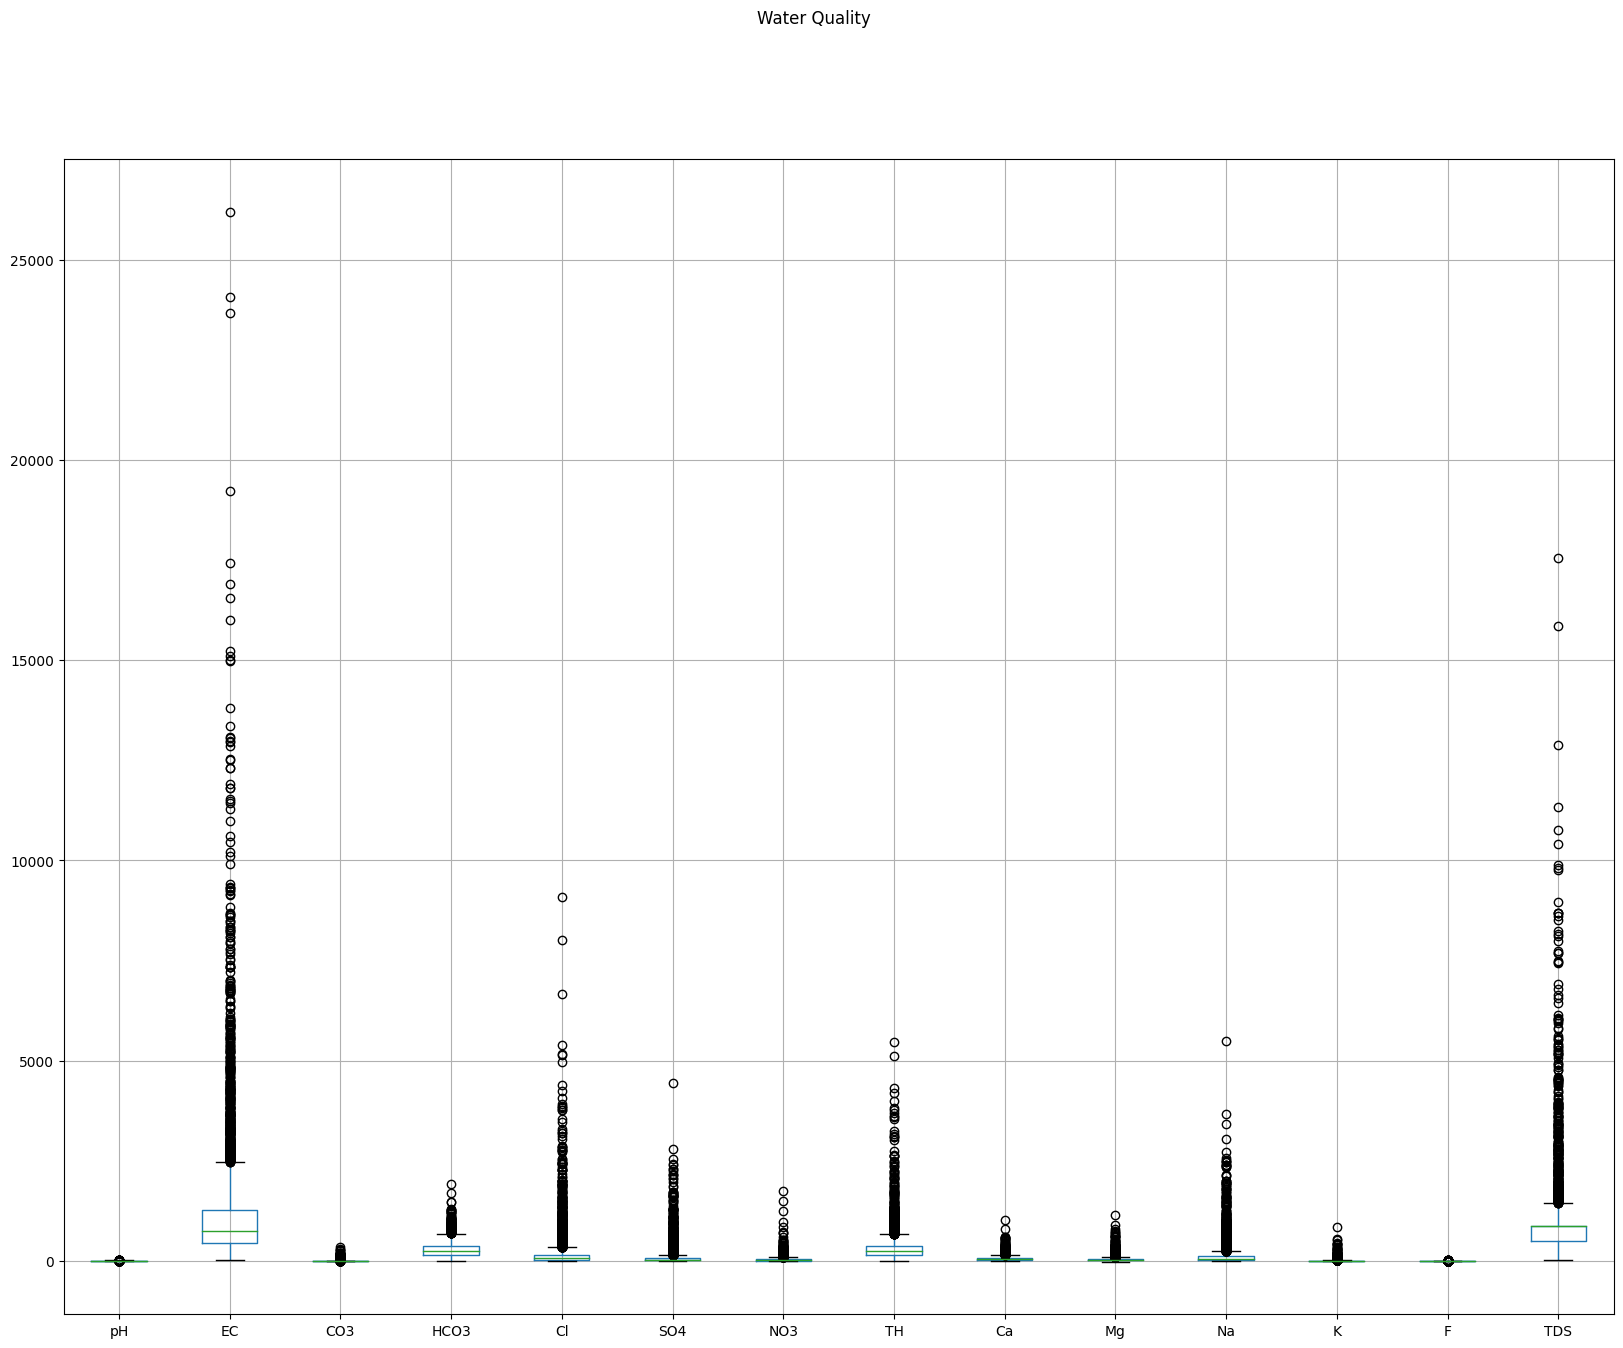

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# Application of IQR for handling outliners

<Axes: >

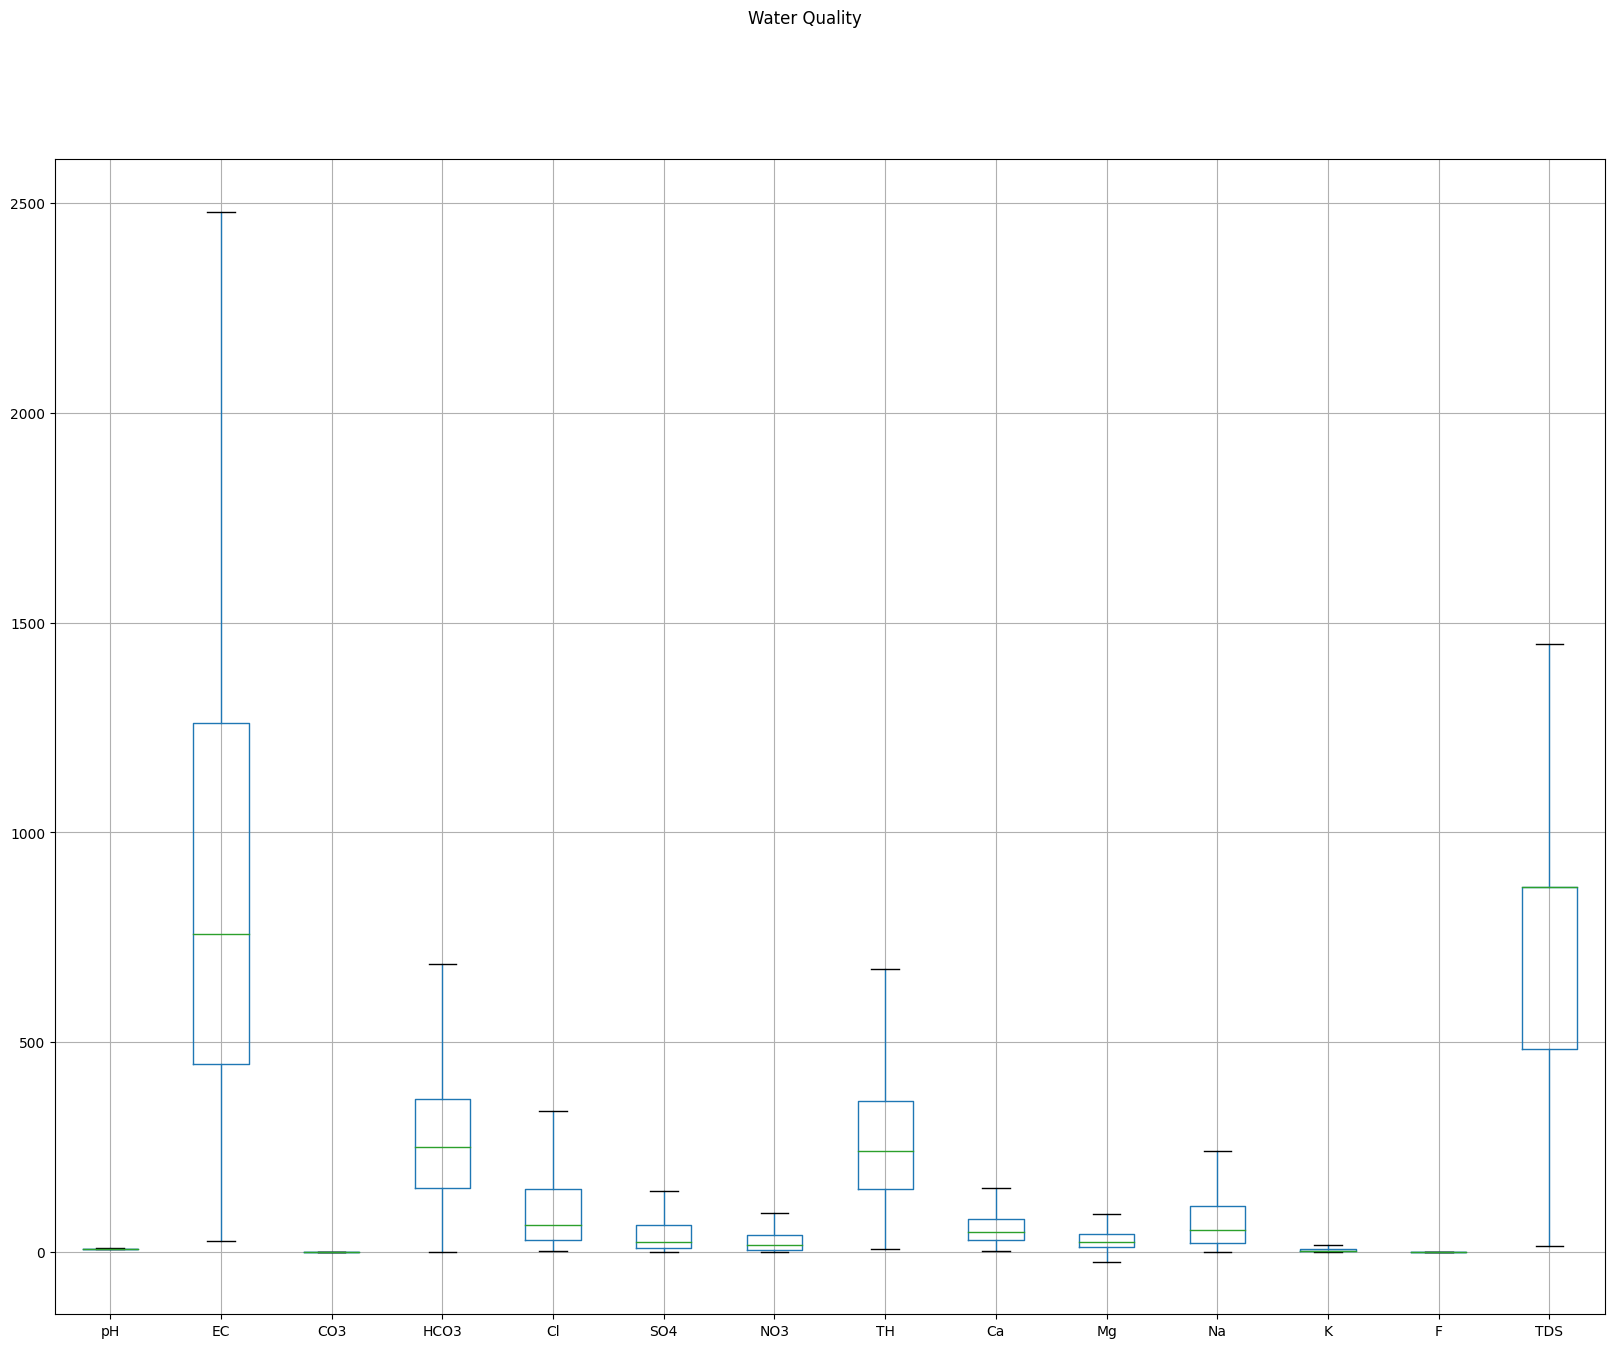

In [ ]:
data_cap = Required_parameters.copy()

def iqr_capping(data, cols, factor):

    for col in cols:

        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)

        iqr = q3 - q1

        upper_whisker = q3 + (factor*iqr)
        lower_whisker = q1 - (factor*iqr)

        data[col] = np.where(data[col]>upper_whisker, upper_whisker,
                 np.where(data[col]<lower_whisker, lower_whisker, data[col]))

iqr_capping(data_cap, Required_parameters, 1.5)
data_cap.shape

plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()
data_cap.boxplot()

# Normalization Min-Max Scalar

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data_cap), columns=data_cap.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.475877,0.131285,0.0,0.266958,0.069524,0.006849,0.010734,0.252169,0.212963,0.396476,0.041456,0.000000,0.567568,0.132839
1,0.383772,0.258141,0.0,0.382203,0.240336,0.034247,0.010734,0.364343,0.332011,0.458150,0.211425,0.060790,0.189189,0.254864
2,0.370614,0.099061,0.0,0.169220,0.099491,0.006849,0.000000,0.177386,0.014550,0.449339,0.041456,0.060790,0.310811,0.094489
3,0.414474,0.115785,0.0,0.231947,0.111477,0.013699,0.000000,0.192342,0.160053,0.352423,0.062184,0.121581,0.250000,0.127261
4,0.510965,1.000000,0.0,0.746900,1.000000,0.383562,0.053670,0.685911,0.358466,0.898678,1.000000,1.000000,0.641892,0.982130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,0.427632,0.110605,0.0,0.035624,0.207072,0.000000,0.026191,0.080168,0.054299,0.277445,0.095349,0.232827,0.141892,0.097138
5371,0.405702,0.024604,0.0,0.053435,0.026476,0.063904,0.009446,0.050254,0.041071,0.245374,0.028149,0.215805,0.182432,0.020479
5372,0.366228,0.058272,0.0,0.097958,0.037099,0.209247,0.017282,0.102602,0.080754,0.288106,0.075243,0.148936,0.243243,0.050637
5373,0.357456,0.101101,0.0,0.124683,0.143332,0.106164,0.014491,0.214777,0.120503,0.416388,0.025454,0.518541,0.304054,0.090863


# Water Quality Index (WQI) Calculation

In [ ]:
# Define Weight for each parameter
weights = {
    'pH': 0.10,    # Weight assigned to pH
    'EC': 0.12,    # Weight assigned to Electrical Conductivity
    'Cl': 0.08,    # Weight assigned to Chloride
    'TH': 0.10,    # Weight assigned to Total Hardness
    'Ca': 0.10,    # Weight assigned to Calcium
    'Mg': 0.10,    # Weight assigned to Magnesium
    'TDS': 0.15,   # Weight assigned to Total Dissolved Solids
    'HCO3': 0.08,  # Weight assigned to Bicarbonate
    'CO3': 0.07,   # Weight assigned to Carbonate
    'SO4': 0.08,   # Weight assigned to Sulfate
    'NO3': 0.05,   # Weight assigned to Nitrate
    'Na': 0.08,    # Weight assigned to Sodium
    'K': 0.07,     # Weight assigned to Potassium
    'F': 0.07      # Weight assigned to Fluoride
}

# Standard ranges for each parameter
standard_ranges = {
    'pH': [6.5, 8.5],   # pH level
    'EC': [50, 800],    # Electrical Conductivity (μS/cm)
    'Cl': [250, 600],   # Chloride (mg/L)
    'TH': [100, 300],   # Total Hardness (mg/L CaCO3)
    'Ca': [20, 120],    # Calcium (mg/L)
    'Mg': [10, 50],     # Magnesium (mg/L)
    'TDS': [300, 2000], # Total Dissolved Solids (mg/L)
    'HCO3': [0, 400],   # Bicarbonate (mg/L)
    'CO3': [0, 200],    # Carbonate (mg/L)
    'SO4': [0, 400],    # Sulfate (mg/L)
    'NO3': [0, 50],     # Nitrate (mg/L)
    'Na': [0, 200],     # Sodium (mg/L)
    'K': [0, 50],       # Potassium (mg/L)
    'F': [0, 2]         # Fluoride (mg/L)
}

# Create an empty list to store WQI values for each row
wqi_values = []

# Loop through each row
for index, row in Required_parameters.iterrows():

    # Initialize WQI for the current row
    wqi = 0

    # Loop through each parameter for the current row
    for param in Required_parameters.columns:
        # Calculate sub-index for the current parameter
        sub_index = 100 * (row[param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

        # Add to the WQI for the current row
        wqi += sub_index * weights[param]

    # Append the WQI value to the list
    wqi_values.append(wqi)

# Add the WQI values as a new column to the original DataFrame
df['WQI'] = wqi_values
normalized_data['WQI']= wqi_values

# Display the DataFrame with WQI values
print(df)
print(normalized_data)


               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...    SO4   NO3  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Classification of samples based on WQI into multiple classes AND SMOTE

In [ ]:
# 0-25  very bad
# 25-50 bad
# 50-70 Medium
# 70-90 Good
# 90-100 Excellent

# Multiclass Classification is used for more detailed results
df['Potability'] = df['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))
normalized_data['Potability'] = normalized_data['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))

# Display the DataFrame
# print(df)
print(normalized_data)

            pH        EC  CO3      HCO3        Cl       SO4       NO3  \
0     0.475877  0.131285  0.0  0.266958  0.069524  0.006849  0.010734   
1     0.383772  0.258141  0.0  0.382203  0.240336  0.034247  0.010734   
2     0.370614  0.099061  0.0  0.169220  0.099491  0.006849  0.000000   
3     0.414474  0.115785  0.0  0.231947  0.111477  0.013699  0.000000   
4     0.510965  1.000000  0.0  0.746900  1.000000  0.383562  0.053670   
...        ...       ...  ...       ...       ...       ...       ...   
5370  0.427632  0.110605  0.0  0.035624  0.207072  0.000000  0.026191   
5371  0.405702  0.024604  0.0  0.053435  0.026476  0.063904  0.009446   
5372  0.366228  0.058272  0.0  0.097958  0.037099  0.209247  0.017282   
5373  0.357456  0.101101  0.0  0.124683  0.143332  0.106164  0.014491   
5374  0.357456  0.052031  0.0  0.053435  0.090216  0.064247  0.052274   

            TH        Ca        Mg        Na         K         F       TDS  \
0     0.252169  0.212963  0.396476  0.041456 

In [ ]:
#df['Potability'].value_counts()
normalized_data['Potability'].value_counts()

Potability
1    1656
0    1285
4    1046
2     859
3     529
Name: count, dtype: int64

In [ ]:
normalized_data2 = normalized_data.drop(columns=['Potability','WQI'])

In [ ]:
normalized_data2

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.475877,0.131285,0.0,0.266958,0.069524,0.006849,0.010734,0.252169,0.212963,0.396476,0.041456,0.000000,0.567568,0.132839
1,0.383772,0.258141,0.0,0.382203,0.240336,0.034247,0.010734,0.364343,0.332011,0.458150,0.211425,0.060790,0.189189,0.254864
2,0.370614,0.099061,0.0,0.169220,0.099491,0.006849,0.000000,0.177386,0.014550,0.449339,0.041456,0.060790,0.310811,0.094489
3,0.414474,0.115785,0.0,0.231947,0.111477,0.013699,0.000000,0.192342,0.160053,0.352423,0.062184,0.121581,0.250000,0.127261
4,0.510965,1.000000,0.0,0.746900,1.000000,0.383562,0.053670,0.685911,0.358466,0.898678,1.000000,1.000000,0.641892,0.982130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,0.427632,0.110605,0.0,0.035624,0.207072,0.000000,0.026191,0.080168,0.054299,0.277445,0.095349,0.232827,0.141892,0.097138
5371,0.405702,0.024604,0.0,0.053435,0.026476,0.063904,0.009446,0.050254,0.041071,0.245374,0.028149,0.215805,0.182432,0.020479
5372,0.366228,0.058272,0.0,0.097958,0.037099,0.209247,0.017282,0.102602,0.080754,0.288106,0.075243,0.148936,0.243243,0.050637
5373,0.357456,0.101101,0.0,0.124683,0.143332,0.106164,0.014491,0.214777,0.120503,0.416388,0.025454,0.518541,0.304054,0.090863


SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming your data is stored in a pandas DataFrame called 'data'
# with the target variable named 'Potability'

# First, split your data into features (X) and target variable (y)
X = df[['pH','EC','CO3','HCO3','Cl','SO4','NO3','TH','Ca','Mg','Na','K','F','TDS']]
y = df['Potability']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Potability'])], axis=1)

# Now 'resampled_data' contains your balanced dataset


In [ ]:
resampled_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,Potability
0,7.740000,349.000000,0.000000,183.000000,25.000000,1.000000,1.000000,175.000000,34.000000,22.000000,10.000000,0.000000,0.840000,206.000000,0
1,7.530000,660.000000,0.000000,262.000000,82.000000,5.000000,1.000000,250.000000,52.000000,29.000000,51.000000,1.000000,0.280000,381.000000,1
2,7.500000,270.000000,0.000000,116.000000,35.000000,1.000000,0.000000,125.000000,4.000000,28.000000,10.000000,1.000000,0.460000,151.000000,0
3,7.600000,311.000000,0.000000,159.000000,39.000000,2.000000,0.000000,135.000000,26.000000,17.000000,15.000000,2.000000,0.370000,198.000000,0
4,7.820000,2501.000000,0.000000,512.000000,560.000000,56.000000,5.000000,465.000000,56.000000,79.000000,336.000000,18.000000,0.950000,1424.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,7.570795,2094.867529,0.000000,231.240502,532.565208,101.629082,62.488663,859.578149,195.611420,89.894024,84.538714,0.685664,0.308145,1403.540769,4
8276,8.161114,2325.401762,0.000000,471.260977,486.923766,95.466264,41.375378,706.903223,38.046928,148.428147,221.000000,27.061581,0.992199,870.131197,4
8277,7.829427,2601.585846,0.000000,252.361161,523.339221,283.370050,147.788591,818.854635,90.748875,144.052880,232.259901,1.192068,0.628238,1740.317169,4
8278,8.699348,1314.802827,37.489399,407.204240,113.438339,127.575795,51.137455,338.468198,16.408480,72.387279,151.341695,54.739523,0.914737,865.880992,4


In [ ]:
resampled_data['Potability'].value_counts()

Potability
0    1656
1    1656
4    1656
2    1656
3    1656
Name: count, dtype: int64

In [ ]:
Required_parameters= resampled_data.drop(columns=["Potability"])

# Boxplot to view outliers

(8280, 14)

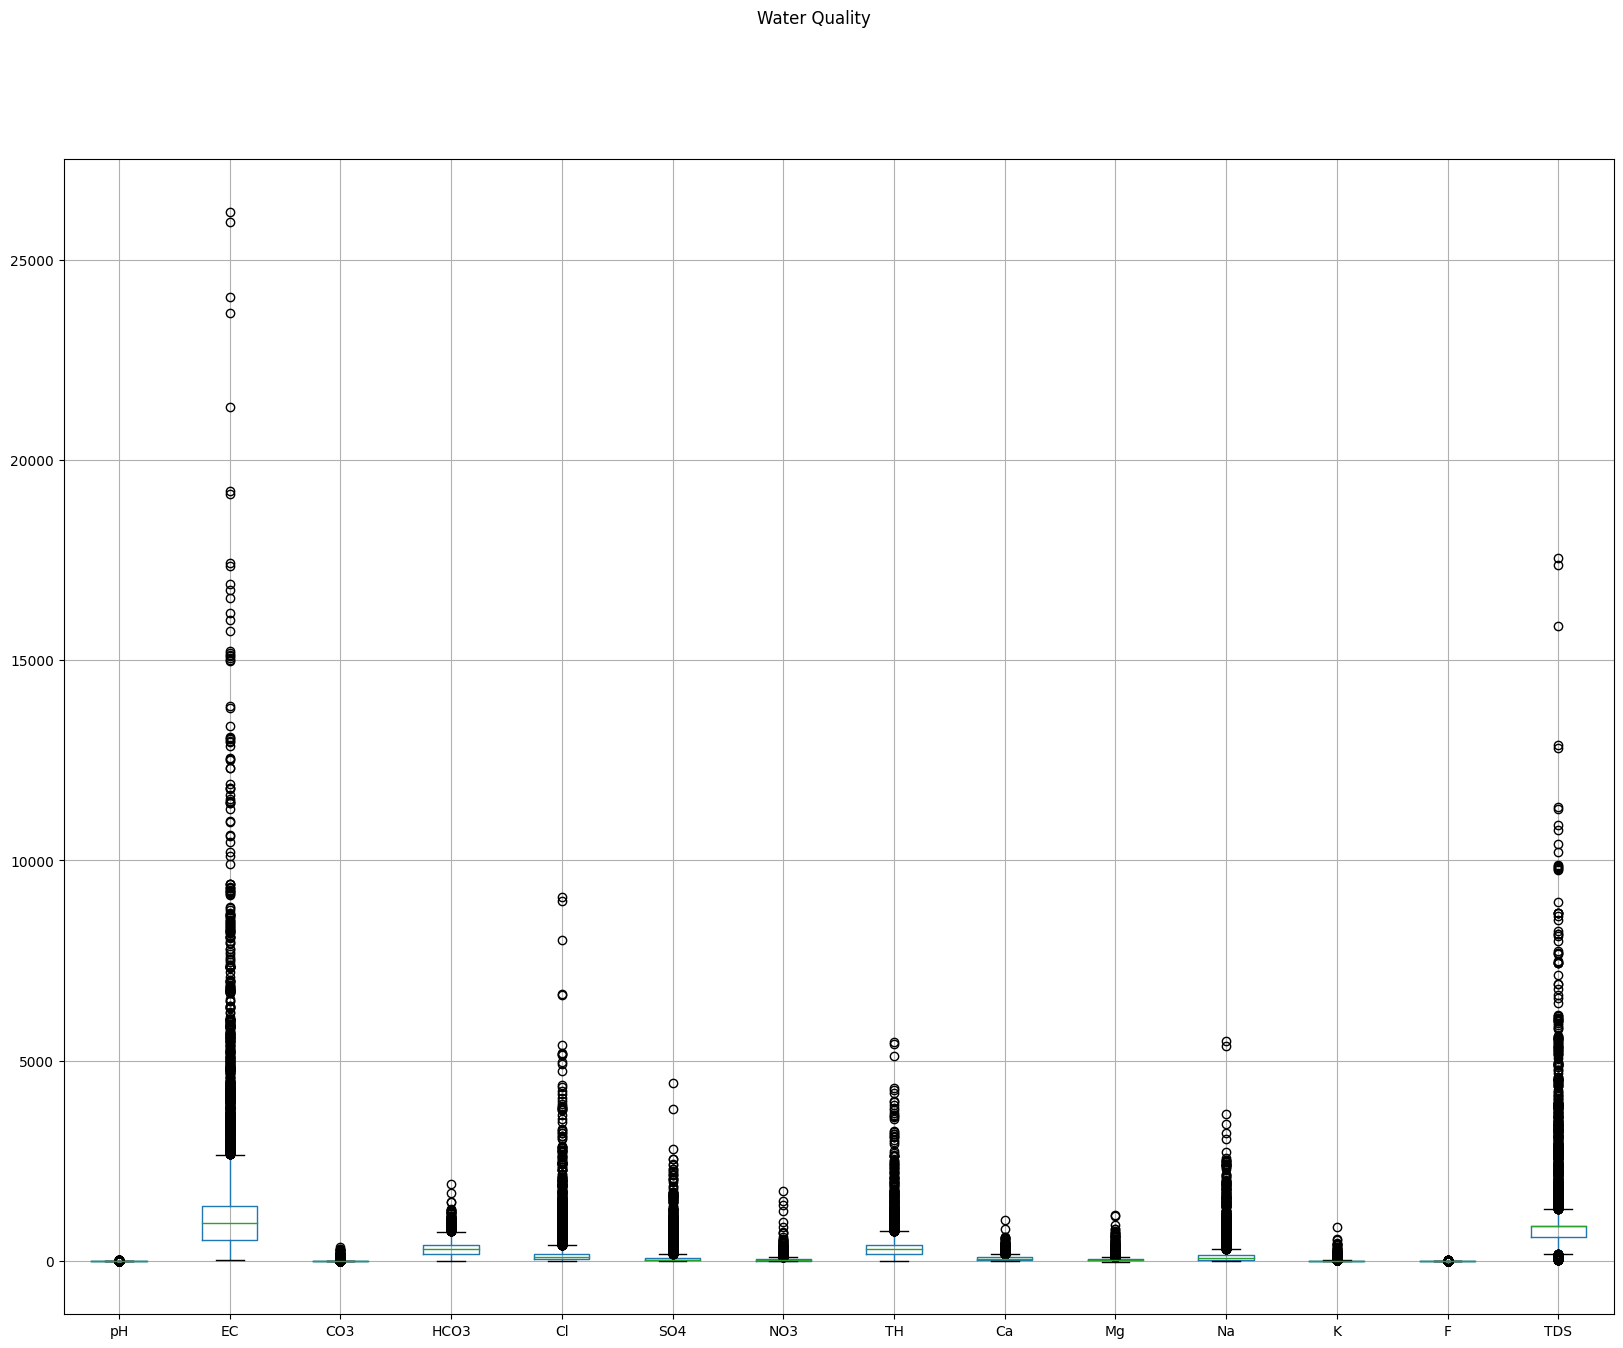

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# Z-score For outlier Handling

Number of outliers using Z-Score method- 729


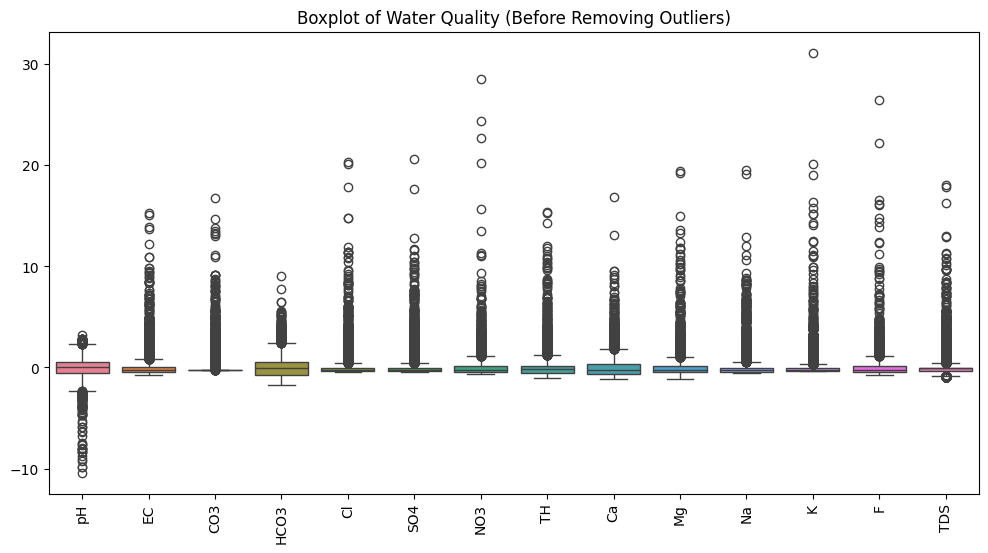

(8280, 14)

In [ ]:
#remove outliner by z-score
from scipy import stats
# Here, almost all kde plots are Gaussian Like
# Using Z-Score Normalization to detect outliers
df_num_final = Required_parameters
df_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 5]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
Required_parameters.iloc[indices_arr, :]


#Remove outliners using z-score
# Calculate Z-scores for each column
z_scores = stats.zscore(df_final_norm)

threshold = 3

# Identify and remove rows with Z-scores above the threshold
indices_arr = (abs(z_scores) > threshold).any(axis=1)
df_no_outliers = df_final_norm[~indices_arr]

# Print the resulting DataFrame without outliers
# print(df_no_outliers)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(df_final_norm)
plt.title("Boxplot of Water Quality (Before Removing Outliers)")
plt.xticks(rotation=90)
plt.show()

df_final_norm.shape

# Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(df_final_norm), columns=df_final_norm.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.756058,0.012297,0.000000,0.095561,0.002557,0.000226,0.000571,0.030947,0.031812,0.038827,0.001822,0.000000,0.037668,0.010862
1,0.722132,0.024180,0.000000,0.136815,0.008839,0.001129,0.000571,0.044714,0.049595,0.044866,0.009291,0.001186,0.012556,0.020840
2,0.717286,0.009279,0.000000,0.060574,0.003659,0.000226,0.000000,0.021770,0.002173,0.044003,0.001822,0.001186,0.020628,0.007726
3,0.733441,0.010846,0.000000,0.083029,0.004100,0.000451,0.000000,0.023605,0.023908,0.034513,0.002733,0.002372,0.016592,0.010406
4,0.768982,0.094520,0.000000,0.267363,0.061522,0.012641,0.002857,0.084178,0.053547,0.088007,0.061213,0.021352,0.042601,0.080310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.728723,0.079003,0.000000,0.120752,0.058498,0.022941,0.035708,0.156605,0.191475,0.097406,0.015401,0.000813,0.013818,0.079143
8276,0.824090,0.087811,0.000000,0.246089,0.053468,0.021550,0.023643,0.128581,0.035810,0.147910,0.040262,0.032102,0.044493,0.048729
8277,0.770505,0.098363,0.000000,0.131781,0.057481,0.063966,0.084451,0.149130,0.087877,0.144135,0.042314,0.001414,0.028172,0.098345
8278,0.911042,0.049198,0.107728,0.212639,0.012304,0.028798,0.029221,0.060953,0.014432,0.082301,0.027572,0.064934,0.041020,0.048487


In [ ]:
'EC','TH','TDS',	'Cl',	'Mg',	'HCO3',	'Na',	'Ca',	'SO4',	'NO3'
1,7,13,4,9,3,10,8,5,6

(1, 7, 13, 4, 9, 3, 10, 8, 5, 6)

# Feature Selection Method - 4. Information Gain

In [ ]:
# Splitting the dataset into features (X) and target (y)
X1_ig = normalized_data
y1_ig = resampled_data['Potability']
# Splitting the dataset into the Training set and Test set
X1_train_ig, X1_test_ig, y1_train_ig, y1_test_ig = train_test_split(X1_ig, y1_ig, test_size=0.2, random_state=0)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X1_ig, y1_ig)
mutual_info

array([0.1216387 , 1.18182871, 0.04797358, 0.53860952, 0.67779811,
       0.39581477, 0.26618991, 0.80460065, 0.42771392, 0.63474598,
       0.58792668, 0.12264766, 0.1847422 , 0.73551918])

In [ ]:
# Checking Values of Mutual info with respect to features in sorted manner.
mutual_info = pd.Series(mutual_info)
mutual_info.index = X1_ig.columns
mutual_info.sort_values(ascending=False)

EC      1.181829
TH      0.804601
TDS     0.735519
Cl      0.677798
Mg      0.634746
Na      0.587927
HCO3    0.538610
Ca      0.427714
SO4     0.395815
NO3     0.266190
F       0.184742
K       0.122648
pH      0.121639
CO3     0.047974
dtype: float64

<Axes: >

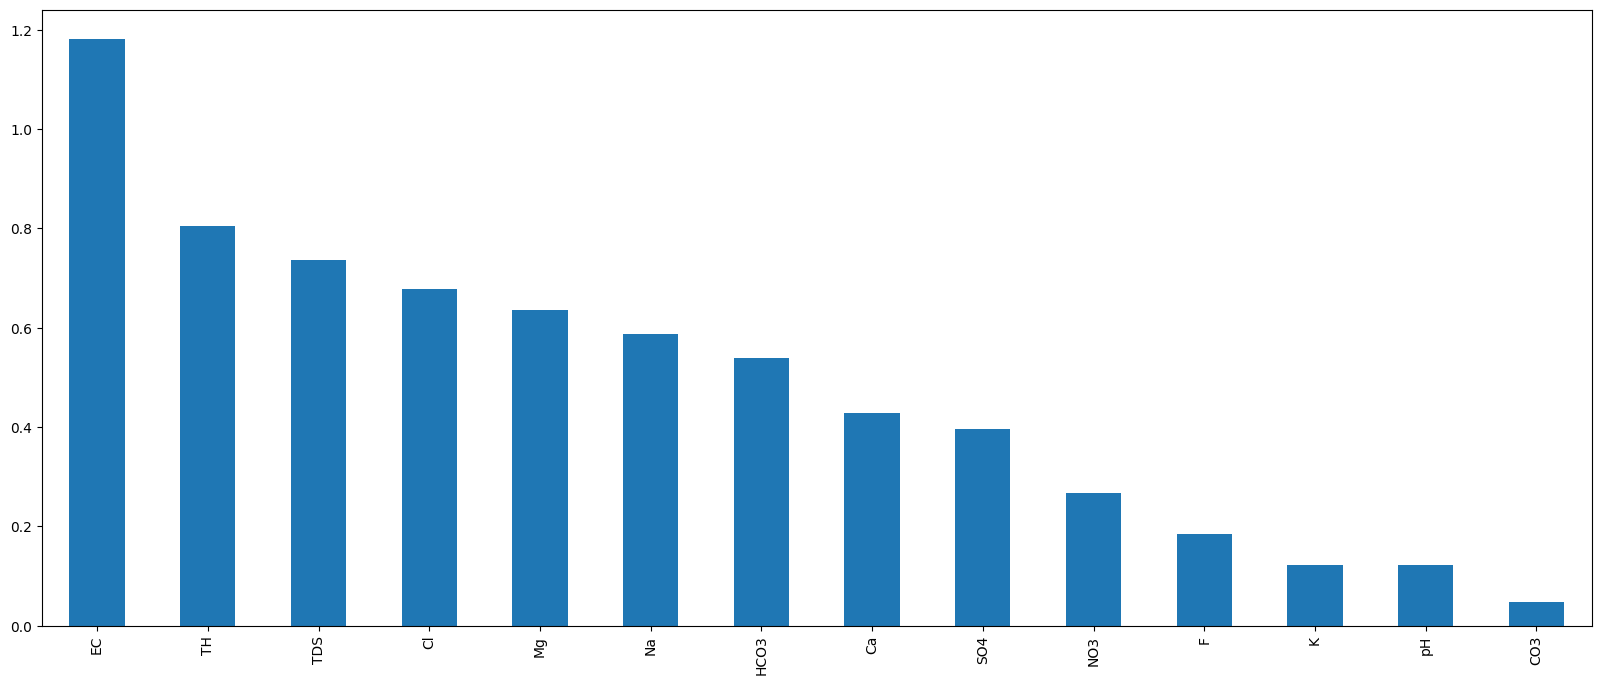

In [ ]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
from sklearn.feature_selection import SelectKBest
#Now we Will select the  top 5 important features
sel_cols = SelectKBest(mutual_info_classif, k=10)
sel_cols.fit(X1_ig, y1_ig)
X1_selected =X1_train_ig.columns[sel_cols.get_support()]


In [ ]:
selected_features =  normalized_data2[['EC','TH','TDS','Cl','Mg','HCO3','Na','Ca','SO4','NO3']]
#selected_features1 = mutual_info.head(10).index.tolist()


In [ ]:
selected_features

,EC,TH,TDS,Cl,Mg,HCO3,Na,Ca,SO4,NO3
0,0.131285,0.252169,0.132839,0.069524,0.396476,0.266958,0.041456,0.212963,0.006849,0.010734
1,0.258141,0.364343,0.254864,0.240336,0.458150,0.382203,0.211425,0.332011,0.034247,0.010734
2,0.099061,0.177386,0.094489,0.099491,0.449339,0.169220,0.041456,0.014550,0.006849,0.000000
3,0.115785,0.192342,0.127261,0.111477,0.352423,0.231947,0.062184,0.160053,0.013699,0.000000
4,1.000000,0.685911,0.982130,1.000000,0.898678,0.746900,1.000000,0.358466,0.383562,0.053670
...,...,...,...,...,...,...,...,...,...,...
5370,0.110605,0.080168,0.097138,0.207072,0.277445,0.035624,0.095349,0.054299,0.000000,0.026191
5371,0.024604,0.050254,0.020479,0.026476,0.245374,0.053435,0.028149,0.041071,0.063904,0.009446
5372,0.058272,0.102602,0.050637,0.037099,0.288106,0.097958,0.075243,0.080754,0.209247,0.017282
5373,0.101101,0.214777,0.090863,0.143332,0.416388,0.124683,0.025454,0.120503,0.106164,0.014491


In [ ]:
selected_features = normalized_data[['EC','TH','TDS',	'Cl',	'Mg',	'HCO3',	'Na',	'Ca',	'SO4',	'NO3']]

In [ ]:
X_ig= selected_features
y_ig= resampled_data['Potability']
# Splitting the dataset into the Training set and Test set
X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(X_ig, y_ig, test_size=0.2, random_state=0)

1 Logistic Regression Info Gain

In [ ]:
# Importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initializing Logistic Regression classifier
ig_lr_model = LogisticRegression()

# Training the Logistic Regression classifier with selected features
ig_lr_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_lr_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_lr_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with logistic regression
ig_lr_cv_scores = cross_val_score(ig_lr_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_lr_cv_scores=np.mean(ig_lr_cv_scores)

# Calculate precision
ig_lr_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_lr_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_lr_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

#Predict probabilities instaed of decision function for ROC AUC
y_probabilities_lr = ig_lr_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_lr_roc_auc = roc_auc_score(y_test_ig, y_probabilities_lr, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_lr_cv_scores)
print("Precision:", ig_lr_precision)
print("Recall:", ig_lr_recall)
print("F1 Score:", ig_lr_f1)
print("ROC AUC Score:", ig_lr_roc_auc)


Training Accuracy: 0.7370169082125604
Testing Accuracy: 0.7542270531400966
Mean Cross-validation score: 0.6527881920430968
Precision: 0.7573590779093236
Recall: 0.7542270531400966
F1 Score: 0.7491196116806803
ROC AUC Score: 0.9417040295509896


In [ ]:
print("Shape of selected_features:", selected_features.shape)
print("Shape of y_test_ig:", y_test_ig.shape)


Shape of selected_features: (8280, 10)
Shape of y_test_ig: (1656,)


2 Random Forest Info Gain

In [ ]:
# Random Forest:
from sklearn.ensemble import RandomForestClassifier

# Initializing Random Forest classifier
ig_rf_model = RandomForestClassifier()

# Training the Random Forest classifier with selected features
ig_rf_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_rf_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_rf_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with Random Forest
ig_rf_cv_scores = cross_val_score(ig_rf_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_rf_cv_scores = np.mean(ig_rf_cv_scores)

# Calculate precision
ig_rf_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_rf_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_rf_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_rf = ig_rf_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_rf_roc_auc = roc_auc_score(y_test_ig, y_probabilities_rf, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_rf_cv_scores)
print("Precision:", ig_rf_precision)
print("Recall:", ig_rf_recall)
print("F1 Score:", ig_rf_f1)
print("ROC AUC Score:", ig_rf_roc_auc)


Training Accuracy: 1.0
Testing Accuracy: 0.9378019323671497
Mean Cross-validation score: 0.8937265679030322
Precision: 0.937609152109548
Recall: 0.9378019323671497
F1 Score: 0.9374353893996588
ROC AUC Score: 0.9955932742717958


3 SVM Info gain

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initializing SVM classifier
ig_svm_model = SVC(probability=True)

# Training the SVM classifier with selected features
ig_svm_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_svm_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_svm_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with SVM
ig_svm_cv_scores = cross_val_score(ig_svm_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_svm_cv_scores = np.mean(ig_svm_cv_scores)

# Calculate precision
ig_svm_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_svm_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_svm_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_svm = ig_svm_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_svm_roc_auc = roc_auc_score(y_test_ig, y_probabilities_svm, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_svm_cv_scores)
print("Precision:", ig_svm_precision)
print("Recall:", ig_svm_recall)
print("F1 Score:", ig_svm_f1)
print("ROC AUC Score:", ig_svm_roc_auc)


Training Accuracy: 0.913647342995169
Testing Accuracy: 0.9057971014492754
Mean Cross-validation score: 0.873799730644633
Precision: 0.907758048707552
Recall: 0.9057971014492754
F1 Score: 0.9059289046996066
ROC AUC Score: 0.9912599478344877


4 Decision Tree Info Gain

In [ ]:
# Importing necessary libraries
from sklearn.tree import DecisionTreeClassifier

# Initializing Decision Tree classifier
ig_dt_model = DecisionTreeClassifier()

# Training the Decision Tree classifier with selected features
ig_dt_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_dt_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_dt_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with Decision Tree
ig_dt_cv_scores = cross_val_score(ig_dt_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_dt_cv_scores = np.mean(ig_dt_cv_scores)

# Calculate precision
ig_dt_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_dt_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_dt_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_dt = ig_dt_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_dt_roc_auc = roc_auc_score(y_test_ig, y_probabilities_dt, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_dt_cv_scores)
print("Precision:", ig_dt_precision)
print("Recall:", ig_dt_recall)
print("F1 Score:", ig_dt_f1)
print("ROC AUC Score:", ig_dt_roc_auc)


Training Accuracy: 1.0
Testing Accuracy: 0.9027777777777778
Mean Cross-validation score: 0.8508590252247661
Precision: 0.9025955703527008
Recall: 0.9027777777777778
F1 Score: 0.9026271337698831
ROC AUC Score: 0.9391112075567016


5 XG-Boost Info Gain

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initializing XGBoost classifier
ig_xgb_model = XGBClassifier()

# Convert target variable to integers using LabelEncoder for both training and test sets
label_encoder = LabelEncoder()
y_train_ig_encoded = label_encoder.fit_transform(y_train_ig)
y_test_ig_encoded = label_encoder.transform(y_test_ig)

# Training the XGBoost classifier with selected features
ig_xgb_model.fit(X_train_ig, y_train_ig_encoded)

# Predicting on training set
ig_y_train_pred = ig_xgb_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig_encoded, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_xgb_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig_encoded, ig_y_test_pred)

# Perform cross-validation with XGBoost
ig_xgb_cv_scores = cross_val_score(ig_xgb_model, X_test_ig, y_test_ig_encoded, cv=5, scoring='accuracy')
ig_xgb_cv_scores = np.mean(ig_xgb_cv_scores)

# Calculate precision
ig_xgb_precision = precision_score(y_test_ig_encoded, ig_y_test_pred, average='weighted')

# Calculate recall
ig_xgb_recall = recall_score(y_test_ig_encoded, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_xgb_f1 = f1_score(y_test_ig_encoded, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_xgb = ig_xgb_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_xgb_roc_auc = roc_auc_score(y_test_ig_encoded, y_probabilities_xgb, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_xgb_cv_scores)
print("Precision:", ig_xgb_precision)
print("Recall:", ig_xgb_recall)
print("F1 Score:", ig_xgb_f1)
print("ROC AUC Score:", ig_xgb_roc_auc)


Training Accuracy: 1.0
Testing Accuracy: 0.9384057971014492
Mean Cross-validation score: 0.8961434863320351
Precision: 0.9379502302904763
Recall: 0.9384057971014492
F1 Score: 0.9379502492763283
ROC AUC Score: 0.9944540504670829


6 KNN info gain


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initializing KNN classifier
ig_knn_model = KNeighborsClassifier()

# Training the KNN classifier with selected features
ig_knn_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_knn_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_knn_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with KNN
ig_knn_cv_scores = cross_val_score(ig_knn_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_knn_cv_scores = np.mean(ig_knn_cv_scores)

# Calculate precision
ig_knn_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_knn_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_knn_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_knn = ig_knn_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_knn_roc_auc = roc_auc_score(y_test_ig, y_probabilities_knn, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_knn_cv_scores)
print("Precision:", ig_knn_precision)
print("Recall:", ig_knn_recall)
print("F1 Score:", ig_knn_f1)
print("ROC AUC Score:", ig_knn_roc_auc)


Training Accuracy: 0.9316123188405797
Testing Accuracy: 0.8967391304347826
Mean Cross-validation score: 0.8460069886797947
Precision: 0.8990634962570634
Recall: 0.8967391304347826
F1 Score: 0.8967548312087471
ROC AUC Score: 0.9839321274800558


7 Gradient Boost Info Gain

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initializing Gradient Boosting classifier
ig_gb_model = GradientBoostingClassifier()

# Determining the mutual information
mutual_info = mutual_info_classif(X_ig, y_ig)

# Training the Gradient Boosting classifier with selected features
ig_gb_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_gb_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_gb_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with Gradient Boosting classifier
ig_gb_cv_scores = cross_val_score(ig_gb_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_gb_cv_scores = np.mean(ig_gb_cv_scores)

# Calculate precision
ig_gb_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_gb_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_gb_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_gb = ig_gb_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_gb_roc_auc = roc_auc_score(y_test_ig, y_probabilities_gb, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_gb_cv_scores)
print("Precision:", ig_gb_precision)
print("Recall:", ig_gb_recall)
print("F1 Score:", ig_gb_f1)
print("ROC AUC Score:", ig_gb_roc_auc)


Training Accuracy: 0.9719202898550725
Testing Accuracy: 0.9124396135265701
Mean Cross-validation score: 0.8870818621919703
Precision: 0.9121479970788554
Recall: 0.9124396135265701
F1 Score: 0.911929883898995
ROC AUC Score: 0.992403433737415


8 MLP Info Gain

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initializing MLP classifier
ig_mlp_model = MLPClassifier()

# Determining the mutual information
mutual_info = mutual_info_classif(X_ig, y_ig)

# Training the MLP classifier with selected features
ig_mlp_model.fit(X_train_ig, y_train_ig)

# Predicting on training set
ig_y_train_pred = ig_mlp_model.predict(X_train_ig)

# Calculating training accuracy
ig_y_train_pred_training_accuracy = accuracy_score(y_train_ig, ig_y_train_pred)

# Predicting on test set
ig_y_test_pred = ig_mlp_model.predict(X_test_ig)

# Calculating testing accuracy
ig_y_test_pred_testing_accuracy = accuracy_score(y_test_ig, ig_y_test_pred)

# Perform cross-validation with MLP classifier
ig_mlp_cv_scores = cross_val_score(ig_mlp_model, X_test_ig, y_test_ig, cv=5, scoring='accuracy')
ig_mlp_cv_scores = np.mean(ig_mlp_cv_scores)

# Calculate precision
ig_mlp_precision = precision_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate recall
ig_mlp_recall = recall_score(y_test_ig, ig_y_test_pred, average='weighted')

# Calculate F1 score
ig_mlp_f1 = f1_score(y_test_ig, ig_y_test_pred, average='weighted')

# Predict probabilities instead of decision function for ROC AUC
y_probabilities_mlp = ig_mlp_model.predict_proba(X_test_ig)

# Calculate ROC AUC score
ig_mlp_roc_auc = roc_auc_score(y_test_ig, y_probabilities_mlp, average='weighted', multi_class='ovr')

print("Training Accuracy:", ig_y_train_pred_training_accuracy)
print("Testing Accuracy:", ig_y_test_pred_testing_accuracy)
print("Mean Cross-validation score:", ig_mlp_cv_scores)
print("Precision:", ig_mlp_precision)
print("Recall:", ig_mlp_recall)
print("F1 Score:", ig_mlp_f1)
print("ROC AUC Score:", ig_mlp_roc_auc)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Training Accuracy: 0.9201388888888888
Testing Accuracy: 0.9142512077294686
Mean Cross-validation score: 0.8756051395915991
Precision: 0.9138961942760288
Recall: 0.9142512077294686
F1 Score: 0.913778264712128
ROC AUC Score: 0.9914547266921118


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Importing necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define your models
estimator_list = [
    ('lr', ig_lr_model),
    ('rf', ig_rf_model),
    ('svm', ig_svm_model),
    ('dt', ig_dt_model),
    ('xgb', ig_xgb_model),
    ('knn', ig_knn_model),
]

# Build stacking model
ig_stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator = KNeighborsClassifier()
)

# Train stacking model
ig_stack_model.fit(X_train_ig, y_train_ig)

# Make predictions
ig_y_train_pred_stack = ig_stack_model.predict(X_train_ig)
ig_y_test_pred_stack = ig_stack_model.predict(X_test_ig)

# Compute model performance metrics
ig_stack_model_train_accuracy = accuracy_score(y_train_ig, ig_y_train_pred_stack)
ig_stack_model_test_accuracy = accuracy_score(y_test_ig, ig_y_test_pred_stack)

# Cross-validation on training dataset using selected features array
ig_stack_cv_scores = cross_val_score(ig_stack_model, X_train_ig, y_train_ig, cv=5, scoring='accuracy')
ig_stack_cv_mean_score = np.mean(ig_stack_cv_scores)

# Precision, Recall, F1-score
ig_precision_stack = precision_score(y_test_ig, ig_y_test_pred_stack, average='weighted')
ig_recall_stack = recall_score(y_test_ig, ig_y_test_pred_stack, average='weighted')
ig_f1_stack = f1_score(y_test_ig, ig_y_test_pred_stack, average='weighted')

# Predict probabilities for ROC AUC
ig_y_probabilities_stack = ig_stack_model.predict_proba(X_test_ig)

# Compute ROC AUC score
ig_roc_auc_stack = roc_auc_score(y_test_ig, ig_y_probabilities_stack, average='weighted', multi_class='ovr')

# Print results
print('Model performance for Training set')
print('- Accuracy:', ig_stack_model_train_accuracy)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy:', ig_stack_model_test_accuracy)
print("Mean CV Score on training data:", ig_stack_cv_mean_score)
print('Precision:', ig_precision_stack)
print('Recall:', ig_recall_stack)
print('F1-score:', ig_f1_stack)
print('ROC AUC:', ig_roc_auc_stack)


Model performance for Training set
- Accuracy: 0.9989432367149759
----------------------------------
Model performance for Test set
- Accuracy: 0.9365942028985508
Mean CV Score on training data: 0.937803454369264
Precision: 0.9362734604982426
Recall: 0.9365942028985508
F1-score: 0.9362854179490612
ROC AUC: 0.9845058205731723


#Hyperparameter Tunning For Information Gain

In [ ]:
X_ig_hy = X_ig.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values
y_ig_hy= y_ig
# Splitting the dataset into the Training set and Test set
X_ig_hy_train, X_ig_hy_test, y_ig_hy_train, y_ig_hy_test = train_test_split(X_ig_hy, y_ig_hy, test_size=0.2, random_state=42)

Logistic regression with hyper tunning

In [ ]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Splitting the dataset into the Training set and Test set
X_ig_hy_train, X_ig_hy_test, y_ig_hy_train, y_ig_hy_test = train_test_split(X_ig_hy, y_ig_hy, test_size=0.2, random_state=42)

# Specify parameters
c_values = list(np.arange(1, 10))

param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver': ['liblinear'], 'multi_class': ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr']}
]

grid_lr = GridSearchCV(ig_lr_model, param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X_ig_hy_train, y_ig_hy_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

# Predictions
predictionforest = grid_lr.best_estimator_.predict(X_ig_hy_test)

# Train accuracy
y_train_pred = grid_lr.best_estimator_.predict(X_ig_hy_train)
ig_lr_training_data_accuracy_hy = accuracy_score(y_ig_hy_train, y_train_pred)
print("Training accuracy:", ig_lr_training_data_accuracy_hy)

# y_pred2 = grid.best_estimator_.predict_proba(X1_test)
y_pred1 = ig_lr_model.predict_proba(X_ig_hy_test)

# Classification report
print(metrics.classification_report(y_ig_hy_test, predictionforest, labels=[1, 0]))

ig_lr_test_data_accuracy_hy = accuracy_score(y_ig_hy_test, predictionforest)
print("Testing accuracy: ", ig_lr_test_data_accuracy_hy)

# Cross-validation
ig_lr_cv_scores_hy = cross_val_score(grid_lr, X_ig_hy_train, y_ig_hy_train, cv=5, scoring='accuracy')
ig_lr_cv_scores_hy = np.mean(ig_lr_cv_scores_hy)

# Precision score on test data
precision_lr_hy = precision_score(y_ig_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_lr_hy = recall_score(y_ig_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_lr_hy = f1_score(y_ig_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_lr_hy = grid_lr.predict_proba(X_ig_hy_test)

# ROC area under the curve score
roc_auc_lr_hy = roc_auc_score(y_ig_hy_test, y_probabilities_lr_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ig_lr_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ig_lr_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ig_lr_cv_scores_hy)
print('Precision:', precision_lr_hy)
print('Recall:', recall_lr_hy)
print('F1-score:', f1_lr_hy)
print('ROC area:', roc_auc_lr_hy)


{'C': 9, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
0.8023829447642934
LogisticRegression(C=9, multi_class='ovr', penalty='l1', solver='liblinear')
Training accuracy: 0.8118961352657005
              precision    recall  f1-score   support

           1       0.80      0.78      0.79       344
           0       0.89      0.98      0.93       307

   micro avg       0.84      0.87      0.86       651
   macro avg       0.84      0.88      0.86       651
weighted avg       0.84      0.87      0.86       651

Testing accuracy:  0.8061594202898551


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy score of training data while using Logistic Regression: 0.8118961352657005
Accuracy score of testing data while using Logistic Regression: 0.8061594202898551
Mean CV Score on testing data: 0.8016281137775751
Precision: 0.7996879012324887
Recall: 0.8061594202898551
F1-score: 0.8011537786589058
ROC area: 0.9422287296033305


Random Forest with hyper tunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Specify parameters for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search Cross-Validation
random_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
random_search_rf.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", random_search_rf.best_params_)
print("Best Accuracy Score: ", random_search_rf.best_score_)
print("Best Estimator: ", random_search_rf.best_estimator_)

# Make predictions using the best model
prediction_rf = random_search_rf.best_estimator_.predict(X_ig_hy_test)
y_pred_rf = random_search_rf.best_estimator_.predict_proba(X_ig_hy_test)

# Training Accuracy
ig_rf_training_accuracy = random_search_rf.best_estimator_.score(X_ig_hy_train, y_ig_hy_train)
print("Training Accuracy:", ig_rf_training_accuracy)

# Testing Accuracy
ig_rf_testing_accuracy = accuracy_score(y_ig_hy_test, prediction_rf)
print("Testing Accuracy:", ig_rf_testing_accuracy)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_rf))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_rf, labels=[1, 0]))

# Precision, Recall, F1-Score
precision_rf = precision_score(y_ig_hy_test, prediction_rf, average='weighted')
recall_rf = recall_score(y_ig_hy_test, prediction_rf, average='weighted')
f1_rf = f1_score(y_ig_hy_test, prediction_rf, average='weighted')
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-Score:", f1_rf)

# Mean Cross-Validation Score
mean_cv_score_rf = random_search_rf.best_score_
print("Mean Cross-Validation Score:", mean_cv_score_rf)

# Compute ROC AUC Score
roc_auc_rf = roc_auc_score(y_ig_hy_test, y_pred_rf, average='weighted', multi_class='ovr')
print("ROC area:", roc_auc_rf)


Best Parameters:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best Accuracy Score:  0.9352357065496208
Best Estimator:  RandomForestClassifier(max_depth=20, n_estimators=150)
Training Accuracy: 1.0
Testing Accuracy: 0.9371980676328503
Confusion Matrix:
 [[298   9   0   0   0]
 [ 21 304  19   0   0]
 [  0  12 314  16   0]
 [  0   0   9 320   7]
 [  0   0   0  11 316]]
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.88      0.91       344
           0       0.93      0.97      0.95       307

   micro avg       0.93      0.92      0.93       651
   macro avg       0.93      0.93      0.93       651
weighted avg       0.93      0.92      0.93       651

Precision: 0.9373982468712703
Recall: 0.9371980676328503
F1-Score: 0.9370242775096579
Mean Cross-Validation Score: 0.9352357065496208
ROC area: 0.9952619751000366


SVM with hyper tunning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Specify parameters for SVM
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'rbf', 'poly']
gamma_values = ['scale', 'auto']

param_grid_svm = {
    'C': C_values,
    'kernel': kernel_values,
    'gamma': gamma_values
}

# Perform Grid Search Cross-Validation
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_svm.best_params_)
print("Best Training Accuracy Score: ", grid_svm.best_score_)
print("Best Estimator: ", grid_svm.best_estimator_)

# Make predictions using the best model
prediction_svm = grid_svm.best_estimator_.predict(X_ig_hy_test)
y_pred_svm = grid_svm.best_estimator_.decision_function(X_ig_hy_test)

# Training Accuracy
ig_svm_training_accuracy = grid_svm.best_estimator_.score(X_ig_hy_train, y_ig_hy_train)
print("Training Accuracy:", ig_svm_training_accuracy)

# Testing Accuracy
ig_svm_testing_accuracy = accuracy_score(y_ig_hy_test, prediction_svm)
print("Testing Accuracy:", ig_svm_testing_accuracy)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_svm))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_svm, labels=[1, 0]))

# Precision, Recall, F1-Score
precision_svm = precision_score(y_ig_hy_test, prediction_svm, average='weighted')
recall_svm = recall_score(y_ig_hy_test, prediction_svm, average='weighted')
f1_svm = f1_score(y_ig_hy_test, prediction_svm, average='weighted')
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-Score:", f1_svm)

# Mean Cross-Validation Score
mean_cv_score_svm = grid_svm.best_score_
print("Mean Cross-Validation Score:", mean_cv_score_svm)
# Compute ROC AUC Score
roc_auc_svm = roc_auc_score(y_ig_hy_test, y_prob_svm, multi_class='ovr', average='macro')
print("ROC area:", roc_auc_svm)



Best Parameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Accuracy Score:  0.9207426323889869
Best Estimator:  SVC(C=10, probability=True)
Training Accuracy: 0.9304045893719807
Testing Accuracy: 0.9178743961352657
Confusion Matrix:
 [[296  11   0   0   0]
 [ 24 300  20   0   0]
 [  0  13 303  26   0]
 [  0   0  19 306  11]
 [  0   0   0  12 315]]
Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.87      0.90       344
           0       0.93      0.96      0.94       307

   micro avg       0.93      0.92      0.92       651
   macro avg       0.93      0.92      0.92       651
weighted avg       0.93      0.92      0.92       651

Precision: 0.9180818219308351
Recall: 0.9178743961352657
F1-Score: 0.9177097003729351
Mean Cross-Validation Score: 0.9207426323889869
ROC area: 0.9929405629655079


Decision Tree with hyper tunning

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy Score:  0.8902460240551786
Best Estimator:  DecisionTreeClassifier()
Training Accuracy: 1.0
Confusion Matrix:
 [[291  16   0   0   0]
 [ 28 282  34   0   0]
 [  0  19 300  23   0]
 [  0   0  17 307  12]
 [  0   1   0  13 313]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       307
           1       0.89      0.82      0.85       344
           2       0.85      0.88      0.87       342
           3       0.90      0.91      0.90       336
           4       0.96      0.96      0.96       327

    accuracy                           0.90      1656
   macro avg       0.90      0.90      0.90      1656
weighted avg       0.90      0.90      0.90      1656

Accuracy:  0.9015700483091788
Precision: 0.9016174126455508
Recall: 0.9015700483091788
F1-Score: 0.9012055098370758
Mean Cross-Validation Score: 0.89024602405517

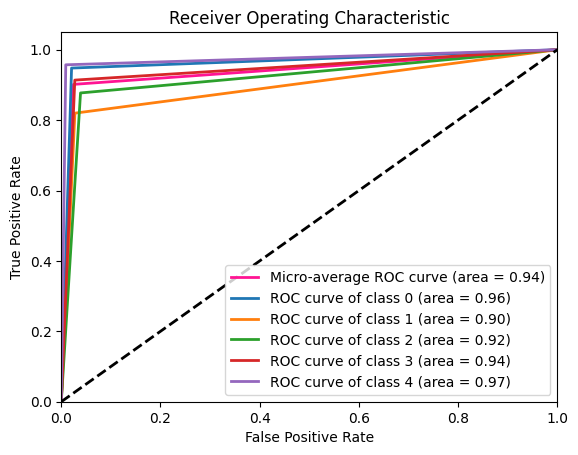

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Specify parameters for Decision Tree
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_dt = {
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}

# Perform Grid Search Cross-Validation
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_dt.best_params_)
print("Best Accuracy Score: ", grid_dt.best_score_)
print("Best Estimator: ", grid_dt.best_estimator_)

# Training accuracy
train_accuracy = accuracy_score(y_ig_hy_train, grid_dt.best_estimator_.predict(X_ig_hy_train))
print("Training Accuracy:", train_accuracy)

# Make predictions using the best model
prediction_dt = grid_dt.best_estimator_.predict(X_ig_hy_test)
y_pred_proba_dt = grid_dt.best_estimator_.predict_proba(X_ig_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_dt))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_dt, labels=np.unique(y_ig_hy_test)))

# Accuracy
ig_dt_acc_hyper = accuracy_score(y_ig_hy_test, prediction_dt)
print("Accuracy: ", ig_dt_acc_hyper)

# Precision, Recall, F1-Score
precision_dt = precision_score(y_ig_hy_test, prediction_dt, average='weighted')
recall_dt = recall_score(y_ig_hy_test, prediction_dt, average='weighted')
f1_dt = f1_score(y_ig_hy_test, prediction_dt, average='weighted')
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-Score:", f1_dt)

# Mean Cross-Validation Score
mean_cv_score_dt = grid_dt.best_score_
print("Mean Cross-Validation Score:", mean_cv_score_dt)

# Binarize the labels
y_ig_hy_test_bin = label_binarize(y_ig_hy_test, classes=np.unique(y_ig_hy_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_ig_hy_test))):
    fpr[i], tpr[i], _ = roc_curve(y_ig_hy_test_bin[:, i], y_pred_proba_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_ig_hy_test_bin.ravel(), y_pred_proba_dt.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Print ROC area for each class and micro-average ROC area
for i in range(len(np.unique(y_ig_hy_test))):
    print("ROC area for class {}: {:.2f}".format(i, roc_auc[i]))
print("Micro-average ROC area: {:.2f}".format(roc_auc["micro"]))

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))
for i in range(len(np.unique(y_ig_hy_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


XGBoost with hyper tunning

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# Convert y_ig_hy_train and y_ig_hy_test to integer type
y_ig_hy_train = y_ig_hy_train.astype(int)
y_ig_hy_test = y_ig_hy_test.astype(int)

# Specify parameters for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [50, 100, 150]
}

# Perform Grid Search Cross-Validation
grid_xgb = GridSearchCV(ig_xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_xgb.best_params_)
print("Best Accuracy Score: ", grid_xgb.best_score_)

# Make predictions using the best model
prediction_xgb = grid_xgb.best_estimator_.predict(X_ig_hy_test)
y_pred_xgb = grid_xgb.best_estimator_.predict_proba(X_ig_hy_test)

# Calculate training and test accuracies
accuracy_train = accuracy_score(y_ig_hy_train, grid_xgb.best_estimator_.predict(X_ig_hy_train))
accuracy_test = accuracy_score(y_ig_hy_test, prediction_xgb)
print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

# Calculate precision, recall, and F1-score
precision_xgb = precision_score(y_ig_hy_test, prediction_xgb, average='weighted')
recall_xgb = recall_score(y_ig_hy_test, prediction_xgb, average='weighted')
f1_xgb = f1_score(y_ig_hy_test, prediction_xgb, average='weighted')
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-Score:", f1_xgb)

# Calculate mean cross-validation score
mean_cv_score_xgb = grid_xgb.best_score_
print("Mean Cross-Validation Score:", mean_cv_score_xgb)

# Compute ROC area
# Compute ROC AUC Score
# roc_auc_svm = roc_auc_score(y_ig_hy_test, y_prob_svm, multi_class='ovr', average='macro')
# print("ROC area:", roc_auc_svm)

roc_area_xgb = roc_auc_score(y_ig_hy_test, y_pred_xgb, multi_class='ovr',average='macro')
print("ROC area:", roc_area_xgb)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_xgb))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_xgb, labels=[1, 0]))


Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Accuracy Score:  0.9391614889129567
Training Accuracy: 1.0
Testing Accuracy: 0.9359903381642513
Precision: 0.9359864277513901
Recall: 0.9359903381642513
F1-Score: 0.9357331817324138
Mean Cross-Validation Score: 0.9391614889129567


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
roc_area_xgb = roc_auc_score(y_ig_hy_test, y_pred_xgb, multi_class='ovr',average='macro')
print("ROC area:", roc_area_xgb)

ROC area: 0.9951075504976871


KNN with hyper tunning

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Specify parameters for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Perform Grid Search Cross-Validation
grid_knn = GridSearchCV(ig_knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_knn.best_params_)
print("Best Accuracy Score: ", grid_knn.best_score_)
# print("Best Estimator: ", grid_knn.best_estimator_)

# Make predictions using the best model
prediction_knn = grid_knn.best_estimator_.predict(X_ig_hy_test)
y_pred_knn = grid_knn.best_estimator_.predict_proba(X_ig_hy_test)

# Print confusion matrix and classification report
# print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_knn))
# print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_knn, labels=[1, 0]))

# Print accuracy score
ig_knn_acc_hyper = accuracy_score(y_ig_hy_test, prediction_knn)
print("Accuracy: ", ig_knn_acc_hyper)

# Calculate training and test accuracies
accuracy_train = accuracy_score(y_ig_hy_train, grid_knn.best_estimator_.predict(X_ig_hy_train))
accuracy_test = accuracy_score(y_ig_hy_test, prediction_knn)
print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

# Calculate precision, recall, and F1-score
precision_knn = precision_score(y_ig_hy_test, prediction_knn, average='weighted')
recall_knn = recall_score(y_ig_hy_test, prediction_knn, average='weighted')
f1_knn = f1_score(y_ig_hy_test, prediction_knn, average='weighted')
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-Score:", f1_knn)

# Calculate mean cross-validation score
mean_cv_score_knn = grid_knn.best_score_
print("Mean Cross-Validation Score:", mean_cv_score_knn)

# Compute ROC area
# Compute ROC AUC Score
# roc_auc_svm = roc_auc_score(y_ig_hy_test, y_prob_svm, multi_class='ovr', average='macro')
# print("ROC area:", roc_auc_svm)

roc_area_knn = roc_auc_score(y_ig_hy_test, y_pred_knn, multi_class='ovr',average='macro')
print("ROC area:", roc_area_knn)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_knn))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_knn, labels=[1, 0]))



Best Parameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best Accuracy Score:  0.9180261072792566
Accuracy:  0.907608695652174
Training Accuracy: 1.0
Testing Accuracy: 0.907608695652174
Precision: 0.9090455368926115
Recall: 0.907608695652174
F1-Score: 0.9069987666254465
Mean Cross-Validation Score: 0.9180261072792566
ROC area: 0.9759281484519015
Confusion Matrix:
 [[297  10   0   0   0]
 [ 40 276  28   0   0]
 [  0  23 302  17   0]
 [  0   0  11 323   2]
 [  0   0   0  22 305]]
Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.80      0.85       344
           0       0.88      0.97      0.92       307

   micro avg       0.89      0.88      0.88       651
   macro avg       0.89      0.88      0.88       651
weighted avg       0.89      0.88      0.88       651



Gradient Boost with hyper tunning

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Specify parameters for Gradient Boosting
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}


# Perform Grid Search Cross-Validation
grid_gb = GridSearchCV(ig_gb_model, param_grid_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_gb.best_params_)
print("Best Accuracy Score: ", grid_gb.best_score_)
# print("Best Estimator: ", grid_gb.best_estimator_)

# Make predictions using the best model
prediction_gb = grid_gb.best_estimator_.predict(X_ig_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_gb))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_gb, labels=[1, 0]))

# Print accuracy score
ig_gb_acc_hyper = accuracy_score(y_ig_hy_test, prediction_gb)
print("Accuracy: ", ig_gb_acc_hyper)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

KeyboardInterrupt: 

MLP with hyper tunning

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Specify parameters for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Initialize MLP classifier
mlp = MLPClassifier(max_iter=500)

# Perform Grid Search Cross-Validation
grid_mlp = GridSearchCV(ig_mlp_model, param_grid_mlp, cv=5, scoring='accuracy')
grid_mlp.fit(X_ig_hy_train, y_ig_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_mlp.best_params_)
print("Best Accuracy Score: ", grid_mlp.best_score_)
# print("Best Estimator: ", grid_mlp.best_estimator_)

# Make predictions using the best model
prediction_mlp = grid_mlp.best_estimator_.predict(X_ig_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_ig_hy_test, prediction_mlp))
print("Classification Report:\n", classification_report(y_ig_hy_test, prediction_mlp, labels=[1, 0]))

# Print accuracy score
ig_mlp_acc_hyper = accuracy_score(y_ig_hy_test, prediction_mlp)
print("Accuracy: ", ig_mlp_acc_hyper)


# Feature Selection Method - 4. Genetic Algorithm





In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

classifiers = ['Logistic','RandomForest','DecisionTree','XGB','KNeighbors','GradientBoosting','MLP']
#'LinearSVM'

models = [LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          #svm.SVC(kernel='linear'),
          DecisionTreeClassifier(random_state=0),
          XGBClassifier(),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          MLPClassifier()]

def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score


In [ ]:
data_bc = normalized_data2
label_bc = normalized_data["Potability"]
#data_bc.drop(columns=['Potability','WQI'], inplace=True)

print("Water Quality:\n",data_bc.shape[0],"Records\n",data_bc.shape[1],"Features")

Water Quality:
 5375 Records
 14 Features


In [ ]:
# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
label_bc = label_encoder.fit_transform(label_bc)

In [ ]:
score1 = acc_score(data_bc,label_bc)
score1

,Classifier,Accuracy
0,MLP,0.953869
1,XGB,0.924851
2,Logistic,0.918155
3,GradientBoosting,0.911458
4,RandomForest,0.910714
5,DecisionTree,0.863839
6,KNeighbors,0.854911


In [ ]:
logmodel = MLPClassifier()
X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
chromo_df_bc,score_bc=generations(data_bc,label_bc,size=80,n_feat=data_bc.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.9508928571428571]
Best score in generation 2 : [0.9598214285714286]
Best score in generation 3 : [0.9568452380952381]
Best score in generation 4 : [0.9642857142857143]
Best score in generation 5 : [0.9598214285714286]


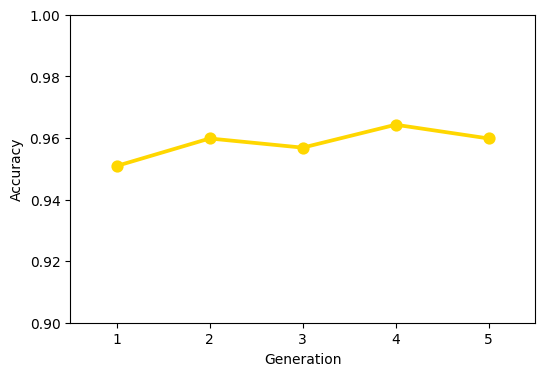

In [ ]:
plot(score_bc,0.9,1.0,c = "gold")

In [ ]:
# Convert the selected features index object into a list of column names
selected_features_list = data_bc.columns[chromo_df_bc[0].tolist()[:len(data_bc.columns)]].tolist()

# Print the selected features
print("Selected Features:")
print(selected_features_list)
# 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'Ca', 'Mg', 'K', 'F', 'TDS'

Selected Features:
['pH', 'EC', 'CO3', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'K', 'TDS']


Hypertunning

# Main data

Data Spliting

In [ ]:
df

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Potability
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545000,92.745830,2021,7.74,...,1.00,175.0,34.00,22.00,10.00,0.00,0.84,206.00,20.281731,0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.602500,92.730000,2021,7.53,...,1.00,250.0,52.00,29.00,51.00,1.00,0.28,381.00,35.834706,1
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.620830,92.730280,2021,7.50,...,0.00,125.0,4.00,28.00,10.00,1.00,0.46,151.00,10.931008,0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.732500,92.708610,2021,7.60,...,0.00,135.0,26.00,17.00,15.00,2.00,0.37,198.00,13.448143,0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.663610,92.658060,2021,7.82,...,5.00,465.0,56.00,79.00,336.00,18.00,0.95,1424.00,133.064361,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,W220500091040001,5371,Tripura,South Tripura,Satchand,Bijaynagar,22.983333,93.822500,2021,7.63,...,2.44,60.0,10.01,8.49,23.00,3.83,0.21,154.80,3.795009,0
5371,W235602091511501,5372,Tripura,Dhalai,Ambassa,Lalchari,23.934164,91.854444,2021,7.58,...,0.88,40.0,8.01,4.85,6.79,3.55,0.27,44.86,-4.488775,0
5372,W230605091513506,5373,Tripura,Gomti,Killa,Dewanbari,23.557778,91.535278,2021,7.49,...,1.61,75.0,14.01,9.70,18.15,2.45,0.36,88.11,2.130211,0
5373,W240824092090501,5374,Tripura,Unakoti,Pecharthal,Karaicherra,24.140000,92.151389,2021,7.47,...,1.35,150.0,20.02,24.26,6.14,8.53,0.45,145.80,13.745726,0


In [ ]:
data_cap.shape

(5375, 14)

In [ ]:
# Splitting the dataset into features (X) and target (y)
X_main = df[['pH','EC','CO3','HCO3','Cl','SO4','NO3','TH','Ca','Mg','Na','K','F','TDS']]
y_main = df['Potability']
# pH	EC	CO3	HCO3	Cl	SO4	NO3	TH	Ca	Mg	Na	K	F	TDS

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_main, y_main, test_size=0.2, random_state=0)

Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler.fit(X_train_main)
scaler.fit(X_test_main)
X_train_main = scaler.transform(X_train_main)

X_test_main = scaler.transform(X_test_main)

print(X_train_main)

[[-0.19579901 -0.6110396  -0.24221466 ... -0.28893798  0.05254167
  -0.94324771]
 [-0.17423591 11.17501163 -0.24221466 ...  0.68420812  0.40788289
  12.59275655]
 [-0.21736212 -0.67331517 -0.24221466 ... -0.29396639 -0.47244634
   0.02760688]
 ...
 [-0.10954659  6.01731681 -0.24221466 ...  0.48011365 -0.3257248
   0.02760688]
 [ 0.06295825 -0.09447171 -0.24221466 ... -0.24752751 -0.24548646
  -0.29566594]
 [-0.64862422 -0.03778497 -0.24221466 ... -0.21499071 -0.0964724
  -0.23104823]]


#Model Implementation

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Create an MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(3,2), max_iter=500, activation='relu')

In [ ]:
# Train the MLP model on the training data
mlp_model.fit(X_train_main,y_train_main)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(3, 2), max_iter=500)

In [ ]:
# Predict labels on the training and testing data
mlp_train_pred = mlp_model.predict(X_train_main)
mlp_test_pred = mlp_model.predict(X_test_main)

In [ ]:
# Calculate training and testing accuracy
mlp_train_accuracy = accuracy_score(y_train_main, mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test_main, mlp_test_pred)

# Calculating the accuracy score
mlp_accuracy = accuracy_score(y_test_main, mlp_test_pred)

In [ ]:
# Print the results
print("Training Accuracy:", mlp_train_accuracy)
print("Testing Accuracy:", mlp_test_accuracy)


Training Accuracy: 0.9888372093023255
Testing Accuracy: 0.9925581395348837


In [ ]:
# # Perform cross-validation
# cv_scores = cross_val_score(mlp_model, X_train_main, y_train_main, cv=5)

# print("Cross-Validation Scores:", cv_scores)
# print("Mean Cross-Validation Score:", cv_scores.mean())

In [ ]:
# pred = mlp.predict (X_test)
# pred

array(['0', '2', '2', ..., '3', '2', '1'], dtype='<U1')

In [ ]:
# confusion_matrix(y_test, pred)
# print (classification_report (y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       584
           1       0.94      0.96      0.95       170
           2       0.91      0.91      0.91        87
           3       0.98      0.97      0.98       234

    accuracy                           0.97      1075
   macro avg       0.96      0.96      0.96      1075
weighted avg       0.97      0.97      0.97      1075



SVM

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import SVC


In [ ]:
# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42) # You can choose a different kernel if needed

In [ ]:
# Train the SVM model on the training data
svm_model.fit(X_train_main, y_train_main)

SVC(kernel='linear', random_state=42)

In [ ]:
# Predict labels on the training and testing data
svm_train_pred = svm_model.predict(X_train_main)
svm_test_pred = svm_model.predict(X_test_main)

In [ ]:
# Calculate training and testing accuracy
svm_train_accuracy = accuracy_score(y_train_main, svm_train_pred)
svm_test_accuracy = accuracy_score(y_test_main, svm_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train_main, y_train_main, cv=5)

In [ ]:
# Print the results
print("Training Accuracy:", svm_train_accuracy)
print("Testing Accuracy:", svm_test_accuracy)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Training Accuracy: 0.9867441860465116
Testing Accuracy: 0.9804651162790697
Cross-Validation Scores: [0.9744186  0.98139535 0.97906977 0.97790698 0.97093023]
Mean Cross-Validation Score: 0.9767441860465116


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Create an KNN classifier
knn_classifier=KNeighborsClassifier(n_neighbors=5)

In [ ]:
#training the knn model with the training data
knn_classifier.fit(X_train_main , y_train_main)

KNeighborsClassifier()

In [ ]:
# Predict labels on the training and testing data
X_train_pred = knn_classifier.predict(X_train_main)
X_test_pred = knn_classifier.predict(X_test_main)

In [ ]:
# Calculate training and testing accuracy
training_data_accuracy= accuracy_score(y_train_main , X_train_pred)
test_data_accuracy=accuracy_score(y_test_main, X_test_pred)
# Perform cross-validation
cv_scores = cross_val_score(knn_classifier, X_train_main, y_train_main, cv=5)

In [ ]:
print('Accuracy score of training data while knn: ' , training_data_accuracy)
print('Accuracy score of testing data while knn: ' , test_data_accuracy)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy score of training data while knn:  0.9090697674418604
Accuracy score of testing data while knn:  0.8613953488372093
Cross-Validation Scores: [0.85       0.85697674 0.83255814 0.8627907  0.85930233]
Mean Cross-Validation Score: 0.8523255813953489


Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Create an Dscision tree classifier
DecTree_classifier = DecisionTreeClassifier()

In [ ]:
#training the knn model with the training data
DecTree_classifier.fit(X_train_main, y_train_main)

DecisionTreeClassifier()

In [ ]:
# Predict labels on the training and testing data
X_train_pred = DecTree_classifier.predict(X_train_main)
X_test_pred = DecTree_classifier.predict(X_test_main)

In [ ]:
# Calculate training and testing accuracy
training_data_accuracy= accuracy_score(y_train_main , X_train_pred)
test_data_accuracy=accuracy_score(y_test_main , X_test_pred)
# Perform cross-validation
cv_scores = cross_val_score(DecTree_classifier, X_train_main, y_train_main, cv=5)

In [ ]:
print('Accuracy score of training data while knn: ' , training_data_accuracy)
print('Accuracy score of testing data while knn: ' , test_data_accuracy)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy score of training data while knn:  1.0
Accuracy score of testing data while knn:  0.8632558139534884
Cross-Validation Scores: [0.8755814  0.90232558 0.86395349 0.85697674 0.87674419]
Mean Cross-Validation Score: 0.8751162790697675


Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
classifier = GradientBoostingClassifier()

# Training the Gradient Boosting model with the training data
classifier.fit(X_train_main, y_train_main)

# Accuracy score on training data
X_train_pred = classifier.predict(X_train_main)
training_data_accuracy = accuracy_score(y_train_main, X_train_pred)

# Accuracy score on test data
X_test_pred = classifier.predict(X_test_main)
test_data_accuracy = accuracy_score(y_test_main, X_test_pred)

# Calculating the accuracy score
gradient_boost_accuracy = accuracy_score(y_test_main, X_test_pred)

print('Accuracy score of training data while using Gradient Boosting: ', training_data_accuracy)
print('Accuracy score of testing data while using Gradient Boosting: ', test_data_accuracy)
print("Accuracy Score:", gradient_boost_accuracy)


Accuracy score of training data while using Gradient Boosting:  0.9941860465116279
Accuracy score of testing data while using Gradient Boosting:  0.9227906976744186
Accuracy Score: 0.9227906976744186


Logistic


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression Classifier
classifier = LogisticRegression()

# Training the Logistic Regression model with the training data
classifier.fit(X_train_main, y_train_main)

# Accuracy score on training data
X_train_pred = classifier.predict(X_train_main)
training_data_accuracy = accuracy_score(y_train_main, X_train_pred)

# Accuracy score on test data
X_test_pred = classifier.predict(X_test_main)
test_data_accuracy = accuracy_score(y_test_main, X_test_pred)

# Calculating the accuracy score
logistic_regression_accuracy = accuracy_score(y_test_main, X_test_pred)

print('Accuracy score of training data while using Logistic Regression: ', training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression: ', test_data_accuracy)
print("Accuracy Score:", logistic_regression_accuracy)


Accuracy score of training data while using Logistic Regression:  0.9758139534883721
Accuracy score of testing data while using Logistic Regression:  0.9674418604651163
Accuracy Score: 0.9674418604651163


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Random Forest and CA
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Training the Random Forest model with the training data
rf_model.fit(X_train_main, y_train_main)

# Accuracy score on training data
rf_X_train_pred = rf_model.predict(X_train_main)
rf_training_data_accuracy = accuracy_score(y_train_main, rf_X_train_pred)

# Accuracy score on test data
rf_X_test_pred = rf_model.predict(X_test_main)
rf_test_data_accuracy = accuracy_score(y_test_main, rf_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rf_cv_scores = cross_val_score(rf_model, X_test_main,y_test_main, cv=5, scoring='accuracy')
rf_cv_scores = np.mean(rf_cv_scores)

print('Accuracy score of training data while using Random Forest:', rf_training_data_accuracy)
print('Accuracy score of testing data while using Random Forest:', rf_test_data_accuracy)
print("Mean CV Score on testing data:", rf_cv_scores)

Accuracy score of training data while using Random Forest: 1.0
Accuracy score of testing data while using Random Forest: 0.9162790697674419
Mean CV Score on testing data: 0.8930232558139535


XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize XGBoost and RFE
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train_main = label_encoder.fit_transform(y_train_main)

# Training the Logistic Regression model with the training data
xgb_model.fit(X_train_main, y_train_main)

# Accuracy score on training data
xgb_X_train_pred = xgb_model.predict(X_train_main)
xgb_training_data_accuracy = accuracy_score(y_train_main, xgb_X_train_pred)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test_main = label_encoder.fit_transform(y_test_main)

# Accuracy score on test data
xgb_X_test_pred = xgb_model.predict(X_test_main)
xgb_test_data_accuracy = accuracy_score(y_test_main, xgb_X_test_pred)

# :Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
xgb_cv_scores = cross_val_score(xgb_model, X_test_main, y_test_main, cv=5, scoring='accuracy')
xgb_cv_scores=np.mean(xgb_cv_scores)


print('Accuracy score of training data while using Logistic Regression: ', xgb_training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression: ', xgb_test_data_accuracy)
print("Mean CV Score on testing data:", np.mean(xgb_cv_scores))


Accuracy score of training data while using Logistic Regression:  1.0
Accuracy score of testing data while using Logistic Regression:  0.9265116279069767
Mean CV Score on testing data: 0.8939534883720931


Building A predictive System

In [ ]:
input_data= (8.45,	1058.0,	6.0,	659.33,	138.255,	19.41,	0.77,	255.0,	32.03,	42.46,	176.72, 0.85,	0.42,	64.15)

input_data_df= pd.DataFrame([input_data], columns=Required_parameters.columns)

wqi = 0

# Loop through each parameter for the current row
for param in Required_parameters.columns:

  # Calculate sub-index for the current parameter
  sub_index = 100 * (input_data_df.iloc[0][param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

  # Add to the WQI for the current row
  wqi += sub_index * weights[param]

print(wqi)

if wqi < 50:
  print("Water is non consumable")
elif wqi < 70:
  print("Water is Good to consume")
elif wqi < 85:
  print("Water is Very Good to consume")
else:
  print("Water Excellent to Consume")

60.83039915966387
Water is Good to consume
